In [19]:
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# general data processing
import pandas as pd
import numpy as np

# text processing
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# ML modeling
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split

In [20]:
df_train = pd.read_csv("./learn-ai-bbc/BBC News Train.csv")
df_test = pd.read_csv("./learn-ai-bbc/BBC News Test.csv")
df_sample_solution = pd.read_csv("./learn-ai-bbc/BBC News Sample Solution.csv")

In [21]:
df_train.columns

Index(['ArticleId', 'Text', 'Category'], dtype='object')

In [22]:
np.unique(df_train.Category)

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [23]:
df_train

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


In [24]:
df_train.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

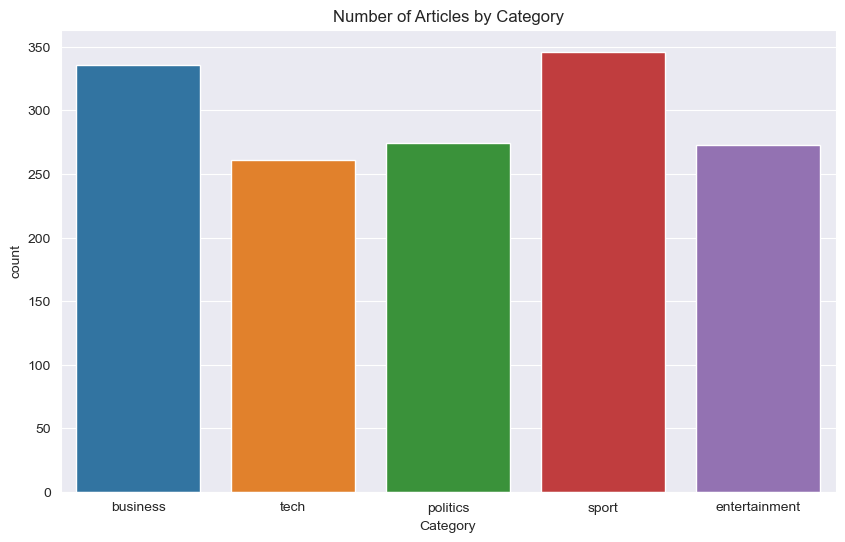

In [25]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x="Category")
plt.title("Number of Articles by Category")
plt.show()

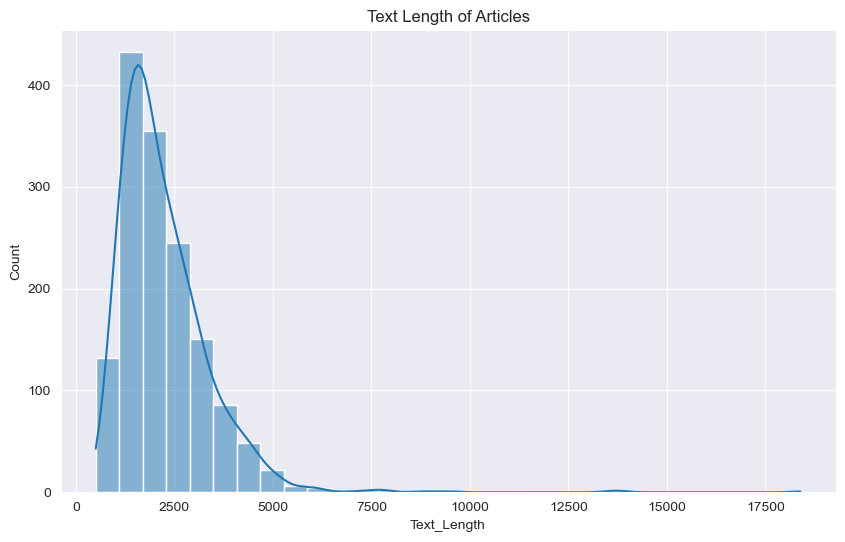

In [26]:
df_train["Text_Length"] = df_train["Text"].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x="Text_Length", bins=30, kde=True)
plt.title("Text Length of Articles")
plt.show()

In [27]:
# if nltk package is not installed, run the following commands
# nltk.download("punkt")
# nltk.download("stopwords")
# nltk.download("wordnet")

def clean_text(text):
    # remove punctuation and numbers
    text = re.sub("[^a-zA-Z]", " ", text)
    # convert text to lowercase
    text = text.lower()
    # remove stop words
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    # lemmatize the words
    cleaned_text = " ".join([lemmatizer.lemmatize(word) for word in words if word not in stop_words])
    return cleaned_text

In [28]:
def train_evaluate_unsupervised_model(fractions, n_components, max_features):
    results = []
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
    X_data = tfidf_vectorizer.fit_transform(df_train['Cleaned_Text'])
    label_encoder = LabelEncoder()
    y_data = label_encoder.fit_transform(df_train['Category'])
    for frac in fractions:
        X_train_frac, X_val, y_train_frac, y_val = train_test_split(X_data, y_data, train_size=frac, random_state=0)
        nmf_model = NMF(n_components=n_components)
        W_train = nmf_model.fit_transform(X_train_frac)
        W_val = nmf_model.transform(X_val)

        # mapping topics to categories
        topic_category_mapping = np.argmax(W_train.T @ np.eye(len(np.unique(y_train_frac)))[y_train_frac], axis=1)

        # training accuracy
        dominant_topics_train = np.argmax(W_train, axis=1)
        predicted_train_categories = topic_category_mapping[dominant_topics_train]
        train_accuracy = accuracy_score(y_train_frac, predicted_train_categories)

        # validation accuracy
        dominant_topics_val = np.argmax(W_val, axis=1)
        predicted_val_categories = topic_category_mapping[dominant_topics_val]
        val_accuracy = accuracy_score(y_val, predicted_val_categories)

        results.append({
            'fraction': frac,
            'n_components': n_components,
            'max_features': max_features,
            'train_accuracy': train_accuracy,
            'val_accuracy': val_accuracy
        })
    return results

In [29]:
def train_evaluate_supervised_models(fractions, max_features):
    results = []
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
    X_data = tfidf_vectorizer.fit_transform(df_train['Cleaned_Text'])
    label_encoder = LabelEncoder()
    y_data = label_encoder.fit_transform(df_train['Category'])
    for frac in fractions:
        X_train_frac, X_val, y_train_frac, y_val = train_test_split(X_data, y_data, train_size=frac, random_state=0)
        
        # SVM 
        svm_model = SVC()
        svm_model.fit(X_train_frac, y_train_frac)
        y_pred_svm_train = svm_model.predict(X_train_frac)
        y_pred_svm_val = svm_model.predict(X_val)
        train_accuracy_svm = accuracy_score(y_train_frac, y_pred_svm_train)
        val_accuracy_svm = accuracy_score(y_val, y_pred_svm_val)
        
        # Random Forest
        rf_model = RandomForestClassifier(n_estimators=100)
        rf_model.fit(X_train_frac, y_train_frac)
        y_pred_rf_train = rf_model.predict(X_train_frac)
        y_pred_rf_val = rf_model.predict(X_val)
        train_accuracy_rf = accuracy_score(y_train_frac, y_pred_rf_train)
        val_accuracy_rf = accuracy_score(y_val, y_pred_rf_val)

        results.append({
            'fraction': frac,
            'model': 'SVM',
            'train_accuracy': train_accuracy_svm,
            'val_accuracy': val_accuracy_svm
        })
        results.append({
            'fraction': frac,
            'model': 'Random Forest',
            'train_accuracy': train_accuracy_rf,
            'val_accuracy': val_accuracy_rf
        })
        
    return results

In [30]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [31]:
df_train["Cleaned_Text"] = df_train["Text"].apply(clean_text)

In [32]:
experiment_results = []
# define parameters for comparison
experiments = [
    {'n_components': 5, 'max_features': 1000},
    {'n_components': 10, 'max_features': 1000},
    {'n_components': 5, 'max_features': 2000},
    {'n_components': 10, 'max_features': 2000},
]
fractions = [0.1, 0.2, 0.5, 0.8]

for exp in experiments:
    exp_results = train_evaluate_unsupervised_model(fractions, **exp)
    experiment_results.extend(exp_results)

# visualize the results
results_df = pd.DataFrame(experiment_results)
print(results_df)

    fraction  n_components  max_features  train_accuracy  val_accuracy
0        0.1             5          1000        0.778523      0.744221
1        0.2             5          1000        0.842282      0.835570
2        0.5             5          1000        0.911409      0.897987
3        0.8             5          1000        0.896812      0.879195
4        0.1            10          1000        0.919463      0.901566
5        0.2            10          1000        0.916107      0.904362
6        0.5            10          1000        0.915436      0.902013
7        0.8            10          1000        0.912752      0.919463
8        0.1             5          2000        0.932886      0.898583
9        0.2             5          2000        0.852349      0.863255
10       0.5             5          2000        0.916779      0.906040
11       0.8             5          2000        0.912752      0.899329
12       0.1            10          2000        0.939597      0.888889
13    

In [33]:
experiment_results = []
fractions = [0.1, 0.2, 0.5, 0.8]
experiments = [
    {'max_features': 1000},
    {'max_features': 2000},
]
for exp in experiments:
    exp_results = train_evaluate_supervised_models(fractions, **exp)
    experiment_results.extend(exp_results)
results_df = pd.DataFrame(experiment_results)

print(results_df)

    fraction          model  train_accuracy  val_accuracy
0        0.1            SVM        1.000000      0.912752
1        0.1  Random Forest        1.000000      0.884415
2        0.2            SVM        1.000000      0.951342
3        0.2  Random Forest        1.000000      0.917785
4        0.5            SVM        0.998658      0.958389
5        0.5  Random Forest        1.000000      0.944966
6        0.8            SVM        1.000000      0.973154
7        0.8  Random Forest        1.000000      0.969799
8        0.1            SVM        1.000000      0.889635
9        0.1  Random Forest        1.000000      0.886652
10       0.2            SVM        1.000000      0.954698
11       0.2  Random Forest        1.000000      0.922819
12       0.5            SVM        1.000000      0.963758
13       0.5  Random Forest        1.000000      0.943624
14       0.8            SVM        0.999161      0.979866
15       0.8  Random Forest        1.000000      0.963087
